# Regression Models

### Table of content
1. Preperation of the data
2. Considering which Linear Regression Model to use
3. Ridge Regression
4. Lasso Regression
5. Elastic Net Regression
4. Best regression model

In [1]:
# Basic Libraries 
import numpy as np 
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

##### 1 .Cleaning the dataset first 
Removing unwanted columns and setting the some values to default. Very much similar to the Dataset used in the EDA in part 1. 

In [2]:
df=pd.read_csv('anime.csv')
df = df.drop(columns = ['anime_id','title_japanese','title_english','title_synonyms','image_url','background','related','opening_theme','ending_theme','aired','producer','licensor','broadcast','premiered'])
df = df[(df['status'] == 'Finished Airing') | (df['status'] == 'Currently Airing')]
## converting the duration columns to integer
def extract_minutes(duration_str):
    # Check if duration string is in expected format
    if isinstance(duration_str, str) and 'min' in duration_str:
        # Extract numeric part of duration string
        minutes_str = duration_str.split()[0]
        # Convert to integer
        minutes = int(minutes_str)
    else:
        # Return missing value if duration string is not in expected format
        minutes = None
    return minutes

# Apply the function to each value in the duration column
df['duration'] = df['duration'].apply(extract_minutes)

import re
from datetime import datetime

# Define function to extract start and end dates from aired_string column
def extract_dates(aired_str):
    # Extract start and end dates using regular expressions
    pattern = r'(\w{3}\s\d{1,2},\s\d{4})\sto\s(\w{3}\s\d{1,2},\s\d{4})'
    matches = re.findall(pattern, aired_str)
    if matches:
        start_date_str, end_date_str = matches[0]
        # Convert start and end dates to datetime objects
        start_date = datetime.strptime(start_date_str, '%b %d, %Y')
        end_date = datetime.strptime(end_date_str, '%b %d, %Y')
        # Calculate number of days between start and end dates
        days = (end_date - start_date).days
        return days
    else:
        return None

# Apply function to aired_string column
df['aired_string'] = df['aired_string'].apply(extract_dates)

df = df[(df['type'] == 'TV') | (df['type'] == 'Movie') | (df['type'] == 'ONA')]

df = df[(df['episodes'] != 0)]

df['aired_string'].fillna(value='1', inplace=True)

# fill the NAN studio with unknown 

df["studio"] = df["studio"].fillna("unknown")

##### Lets check if any of the value is NaN in the dataset 

In [3]:
print(df.isnull().sum())

title             0
type              0
source            0
episodes          0
status            0
airing            0
aired_string      0
duration        306
rating            0
score             0
scored_by         0
rank             11
popularity        0
members           0
favorites         0
studio            0
genre            51
dtype: int64


Cleaning the dataset again

In [4]:
# Remove the rows with NaN rank. 
df = df.dropna(subset=['rank'])
# Fill the duration with 0 if it is lablled NaN. 
df['duration'] = df['duration'].fillna(0)
# Fill the genre with "Indie" if it is lablled NaN.
df["genre"].fillna("Indie", inplace=True)
print(df.isnull().sum())

title           0
type            0
source          0
episodes        0
status          0
airing          0
aired_string    0
duration        0
rating          0
score           0
scored_by       0
rank            0
popularity      0
members         0
favorites       0
studio          0
genre           0
dtype: int64


In [5]:
# Check rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

# Drop rows with NaN values
df.dropna(inplace=True)

Empty DataFrame
Columns: [title, type, source, episodes, status, airing, aired_string, duration, rating, score, scored_by, rank, popularity, members, favorites, studio, genre]
Index: []


In [6]:
df

,title,type,source,episodes,status,airing,aired_string,duration,rating,score,scored_by,rank,popularity,members,favorites,studio,genre
0,Inu x Boku SS,TV,Manga,12,Finished Airing,False,77,24.0,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,David Production,"Comedy, Supernatural, Romance, Shounen"
1,Seto no Hanayome,TV,Manga,26,Finished Airing,False,182,24.0,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,Gonzo,"Comedy, Parody, Romance, School, Shounen"
2,Shugo Chara!! Doki,TV,Manga,51,Finished Airing,False,356,24.0,PG - Children,7.55,37129,1508.0,1173,70127,802,Satelight,"Comedy, Magic, School, Shoujo"
3,Princess Tutu,TV,Original,38,Finished Airing,False,280,16.0,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy"
4,Bakuman. 3rd Season,TV,Manga,25,Finished Airing,False,175,24.0,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,J.C.Staff,"Comedy, Drama, Romance, Shounen"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14443,Hibike! Euphonium Movie: Todoketai Melody - Ph...,Movie,Unknown,3,Finished Airing,False,1,4.0,PG-13 - Teens 13 or older,5.66,35,10480.0,8789,809,1,Kyoto Animation,Comedy
14446,Tobiuo no Boy wa Byouki Desu,Movie,Unknown,1,Finished Airing,False,1,19.0,G - All Ages,6.60,5,12499.0,13793,67,0,unknown,"Fantasy, Historical, Kids"
14465,Mii-chan no Tenohira,Movie,Unknown,1,Finished Airing,False,1,20.0,G - All Ages,6.60,5,11298.0,13318,90,0,unknown,"Historical, Drama"
14466,Mashiro Witch,ONA,Game,1,Finished Airing,False,1,2.0,PG-13 - Teens 13 or older,4.57,7,11242.0,14464,24,0,unknown,"Game, Magic"


# 2. Lets Look at some regression Models 
We have picked 3 different regression models: Ridge Regression, Lasso Regression and Elastic Net Regression. Below are some advantages and disadvantages of the regression models.

### Ridge Regression 
Model tuning method that is used to analyse any data that sufferes from mulitcollinearity.
- Prevent overshifting by reducing the coefficient towards zero
- Useful when dealing with multicollinearity in the dataset. 
- Works well when there are a large number of variables in the data set. 
- Ridge regression does not perfom feature selection.
- Ridge regression assumes all variable are relevant and adds bias to the model. 

### Lasso Regression
The word “LASSO” stands for Least Absolute Shrinkage and Selection Operator. It is a statistical formula for the regularisation of data models and feature selection. Lasso Regression is a regularization technique. The lasso procedure encourages simple, sparse models. 
- Performs feature selection by setting some coefficents to zero.
- Useful when dealing with a large number of variables in the dataset.
- Lasso Regression Model mgiht be unstable and produce different results when the dataset is small.
- It can only be used when the number of observations is greater than the number of vairables. 

### Elastic Net Regression
The elastic net is a regularized regression method. 
- Combines both Ridge and Lasso Regression.
- Useful when dealing with high-dimensional datasets.
- Can perform both feature selection and shrinkage.
- It is computationally more complex than Ridge and Lasso Regression. 
- The model selection process can be challenging. 

# 3. Ridge Regession Model

Using one hot enocoding to change change the Categorial Variables "Rating", "Genre" and "Studio" 

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Select the relevant columns
df = df[['rank', 'members', 'genre', 'studio', 'rating']].dropna()

# Perform one-hot encoding on the categorical variables
df = pd.get_dummies(df, columns=['genre', 'studio', 'rating'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the linear regression model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))

Mean squared error: 7088013.19
R-squared value: 0.50


###### Appplying Cross Validation onto the ridge regression model

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the Ridge regression model with cross-validation
model = Ridge(alpha=1.0)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse = -scores.mean()
r2 = scores.mean()

# Train the Ridge regression model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error on the test set
mse_test = mean_squared_error(y_test, y_pred)

print('Cross-validation scores:', scores)
print('Average cross-validation score:', r2)
print('Mean squared error (test): {:.2f}'.format(mse_test))

Cross-validation scores: [-5775660.69776519 -6125350.26419744 -5966233.10959442 -6177321.57182602
 -6330470.04152745]
Average cross-validation score: -6075007.136982104
Mean squared error (test): 6118357.73


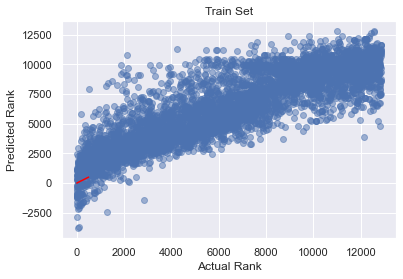

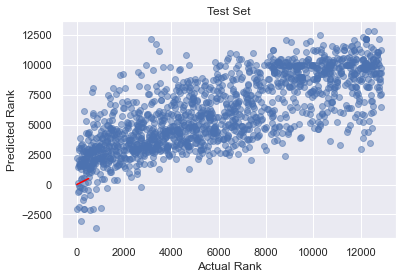

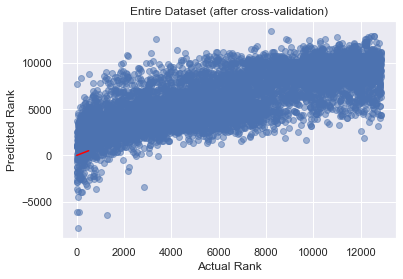

In [9]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for the train set
plt.scatter(y_train, model.predict(X_train), alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Train Set')
plt.show()

# Plot actual vs predicted values for the test set
plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Test Set')
plt.show()

# After cross-validation
from sklearn.model_selection import cross_val_predict

# Perform cross-validation on the model
y_pred_cv = cross_val_predict(model, df.drop('rank', axis=1), df['rank'], cv=5)

# Plot actual vs predicted values for the entire dataset
plt.scatter(df['rank'], y_pred_cv, alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Entire Dataset (after cross-validation)')
plt.show()


###### Observation : 
The mean squared Error of 7,088,013 means that on average the predicted rank from the model is off by about Square root of the MSE = 2662 Ranks.

An R-Squared value of 0.50 means that 50% of the variance in the target variable (in this case, 'rank') can be explained by the linear regression model using the features provided. The other 50% of the variance is unexplained and may be due to other factors that are not accounted for in the model. In general, higher R-Squared values indicate a better fit of the model to the data. However, it is important to keep in mind that R-Squared is not a perfect measure of model performance and should be considered in conjunction with other evaluation metrics.

Cross-Validation is a technquie used to evaluate the performance of the ridge regression model. The dataset is split into several smaller subset and the model is trained on a subset of the data and evaluated on the remaining subset. The result are then averaged to obtain an estimate of the model's performance on the entire dataset.

After cross validation, the mean squared error decreased to 6,075,007. There is a decrease in the MSE after cross validation meaning the predicted rank on average has become accurate. We can observe that the absolute average cross validation score is the same as the mean squared error.

# 4. Lasso Regression Model

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the Lasso regression model on the training set
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: {:.2f}'.format(mse))

Mean squared error: 7112758.77


C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7589421605.88814, tolerance: 8865394.294807097
  model = cd_fast.enet_coordinate_descent(


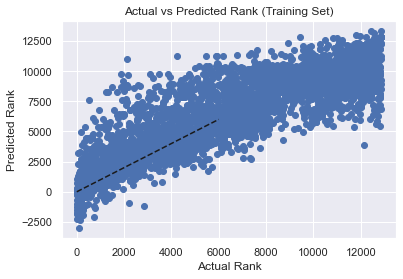

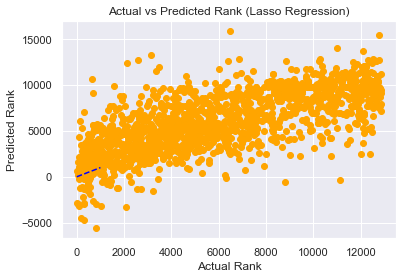

In [11]:
import matplotlib.pyplot as plt

# Predict on the training set
y_train_pred = model.predict(X_train)

# Plot the actual vs predicted values for the training set
plt.scatter(y_train, y_train_pred)
plt.plot([0, 6000], [0, 6000], '--k')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Actual vs Predicted Rank (Training Set)')
plt.show()

# Predict on the testing set
y_test_pred = model.predict(X_test)

# Plot the actual vs predicted values for the testing set
plt.scatter(y_test, y_pred, color='orange')
plt.plot([0, 1000], [0, 1000], color='blue', linestyle='--')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Actual vs Predicted Rank (Lasso Regression)')
plt.show()

The graph shows the actual versus predicted values for the training and testing sets after applying the Lasso regression model. The blue dots represent the actual values, and the orange dots represent the predicted values. By comparing the location of the blue and orange dots, we can get an idea of how well the model is able to predict the ranking of the anime. The closer the dots are to the diagonal line, the better the model is at predicting the rankings.

###### Applying the cross validation onto the Lasso Regression model 

In [12]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the Lasso regression model on the training set
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=3)
print('Cross-validation scores: {}'.format(scores))
print('Average cross-validation score: {:.2f}'.format(scores.mean()))

C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7589421605.88814, tolerance: 8865394.294807097
  model = cd_fast.enet_coordinate_descent(
C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4670877239.047818, tolerance: 5865117.134404379
  model = cd_fast.enet_coordinate_descent(
C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4366801694.386762, tolerance: 5947292.3521646345
  model = cd_fast.enet_coordinate_descent(


Cross-validation scores: [0.50702321 0.47883868 0.47252932]
Average cross-validation score: 0.49


C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4471151634.43408, tolerance: 5918028.483909076
  model = cd_fast.enet_coordinate_descent(


In [13]:
from sklearn.metrics import mean_squared_error

# Compute the mean squared error on the test set
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print('Mean squared error (test set): {:.2f}'.format(mse_test))

# Compute the R-squared value on the test set
r2_test = model.score(X_test, y_test)
print('R-squared value (test set): {:.2f}'.format(r2_test))

Mean squared error (test set): 7112758.77
R-squared value (test set): 0.50


##### Observation :

The cross-validation scores for the Lasso regression model are 0.50702321, 0.47883868, 0.47252932. These scores represent the performance of the model on different folds of the data. A higher score indicates a better fit to the data.

The average cross-validation score of 0.49 tells us that, on average, the Lasso regression model is able to explain about 49% of the variance in the data. This score can be compared to the average cross-validation score of other models to determine which model performs better in terms of predicting the target variable.

After the cross validation on the Lasso Regression model, the MSE has been reduced to 6,118,357 and a R-Squared Value of 0.57.

# 5. Elastic Net Regression Model

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the Elastic Net regression model on the training set
model = ElasticNet(alpha=0.001, l1_ratio=0.5)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean squared error: {:.2f}'.format(mse))
print('R^2 score: {:.2f}'.format(r2))

Mean squared error: 6115407.03
R^2 score: 0.57


C:\Users\jianhong\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15067906818.043861, tolerance: 8865394.294807097
  model = cd_fast.enet_coordinate_descent(


In [15]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('rank', axis=1), df['rank'], test_size=0.2, random_state=42)

# Fit the ElasticNet regression model on the training set
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse = -scores.mean()

print('Mean squared error: {:.2f}'.format(mse))
print('Average cross-validation score: {:.2f}'.format(scores.mean()))

Mean squared error: 7573924.92
Average cross-validation score: -7573924.92


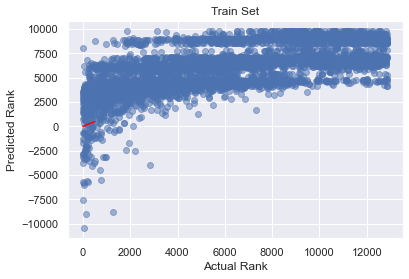

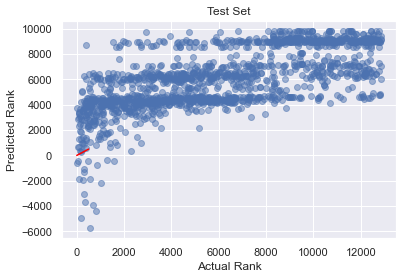

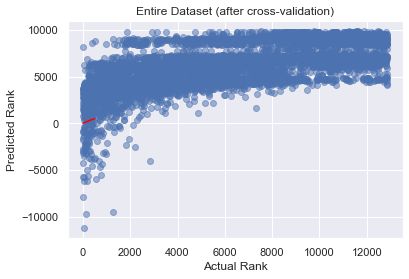

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# Plot actual vs predicted values for the train set
plt.scatter(y_train, model.predict(X_train), alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Train Set')
plt.show()

# Plot actual vs predicted values for the test set
plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Test Set')
plt.show()

# After cross-validation
y_pred_cv = cross_val_predict(model, df.drop('rank', axis=1), df['rank'], cv=5)

# Plot actual vs predicted values for the entire dataset
plt.scatter(df['rank'], y_pred_cv, alpha=0.5)
plt.plot([0, 500], [0, 500], color='red')
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Entire Dataset (after cross-validation)')
plt.show()

##### Observation : 

We can see that applying the Elastic Net Regression Model on the dataframe has Mean squared error of 6,115,407.03 and an R-Squared score of 0.57. After the cross validaation of the model however we can see that the Mean squared error has increased to 7.573.924.92. 

The average cross-validation score of -7,573,924.92 indicates the mean of the scores obtained from cross-validating the model using 3 folds. In this case, a negative value indicates that the model is performing poorly and is worse than predicting the mean target value. 

It's important to note that the score is dependent on the metric used, in this case, the mean squared error. Therefore, a lower score indicates better performance, while a higher score indicates poorer performance.

# 6. Comparison between the regression model

Ranking of regression Models Based on MSE ( Mean Squared Error )
1. Elastic Net Regression Model (6115407.03)
2. Ridge Regressoin Model (7088013.19)
3. Lasso Regression Model (7112758.77)

Ranking of regression Models Based on R-squared value. 
1. Ridge Regression (0.50)
2. Elastic Net Regression Model (0.57) 
3. Lasso Regression (0.57) 

Considering the ranking of the the models. We decided that Elastic Net Regression Model is the better of the three models.
- Firstly it has the lowest mean squared error compared to the Ridge Regression Model and Lasso Regression Model. 
- The R-Squared Error is similar to that of Lasso Regression however higher than the error of Ridge regression. 
- Since Elastic Net Regression Combines both Ridge and Lasso Regression it is able to optimise the benefits of both the other regression models. 

However the disavantages of using Elastic Regression : 
- Computationally more complex than Ridge and Lasso Regression 
- Model selection process can be challenging.